In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [105]:
df = pd.read_csv("C:/Users/salto/Documents/DataAnalytics/Module2.2-EDA_Stats/Day1/Lab/lab-eda-univariate/amz_uk_price_prediction_dataset.csv")

In [106]:
df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


# Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status

## Crosstab Analysis:

* Create a crosstab between the product category and the isBestSeller status.

* Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [109]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result1 = crosstab_result.reset_index()
crosstab_result1['total'] = crosstab_result1[0] + crosstab_result1[1]
crosstab_result1['proportion_best_seller'] = 100*crosstab_result1[1] / crosstab_result1['total']
crosstab_result1 = crosstab_result1.sort_values('proportion_best_seller', ascending=False)
crosstab_result1

isBestSeller,category,False,True,total,proportion_best_seller
109,Grocery,9008,556,9564,5.813467
254,Smart Home Security & Lighting,98,6,104,5.769231
126,Health & Personal Care,9017,552,9569,5.768628
185,Mobile Phone Accessories,248,11,259,4.247104
229,Power & Hand Tools,8353,306,8659,3.533895
...,...,...,...,...,...
38,"CD, Disc & Tape Players",8798,0,8798,0.000000
103,General Music-Making Accessories,259,0,259,0.000000
259,Snowboard Boots,1449,0,1449,0.000000
33,Boxes & Organisers,911,0,911,0.000000


There are no categories where being a best-seller is more prevalent.

## Statistical Tests:

* Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
* Compute Cramér's V to understand the strength of association between best-seller status and category.

In [112]:
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [113]:
from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [114]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.1222829439760564

## Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

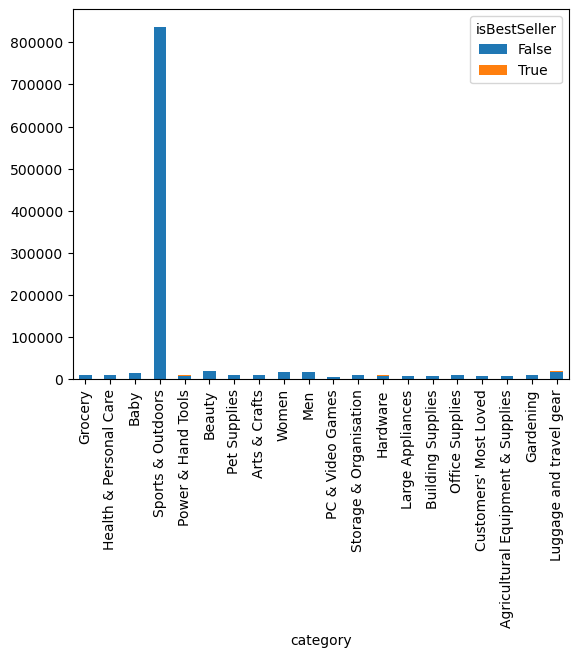

In [116]:
crosstab_result.sort_values(by=True, ascending=False).head(20).plot(kind="bar", stacked=True);

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

## Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [118]:
def tukeys_test_outliers(data, repl_type):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    median_val = np.median(data)
    
    # Replace or discard outliers
    if repl_type == 'median':
        data = pd.Series(np.where(np.logical_or(data < lower_bound, data > upper_bound), median_val, data), index=data.index)
    elif repl_type == 'Tukey':
        data = pd.Series(np.where(data < lower_bound, lower_bound, np.where(data > upper_bound, upper_bound, data)), index=data.index)
    elif repl_type == 'discard':
        data = pd.Series(np.where(np.logical_or(data < lower_bound, data > upper_bound), np.nan, data), index=data.index)
    
    return data

# Example usage:
data_series = df['price']  # replace 'ColumnName' with your specific column
data_series1 = tukeys_test_outliers(data_series, 'discard')

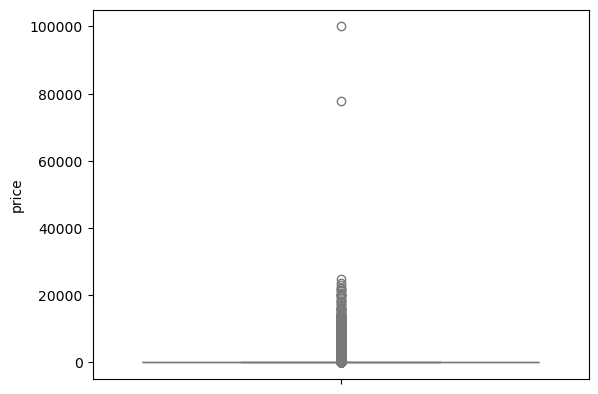

In [140]:
sns.boxplot(data = df['price'], color="lightblue");

In [97]:
len(data_series)

2443651

In [135]:
df['price'].isnull().sum()

0

In [133]:
df1['price'].isnull().sum()

327688

In [144]:
df1 = df.copy()
df1['price'] = data_series1


df1 = df1.dropna(subset=['price'])

In [146]:
df1

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


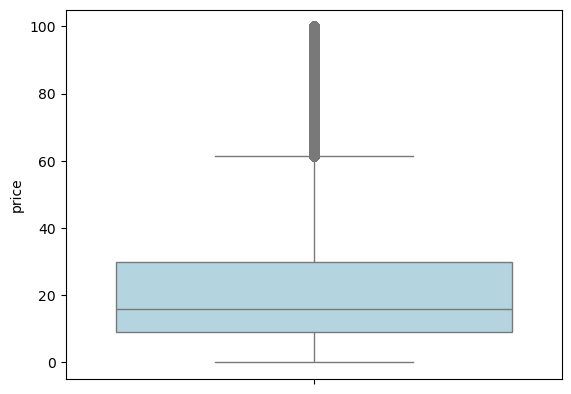

In [148]:
sns.boxplot(data = df1['price'], color="lightblue");

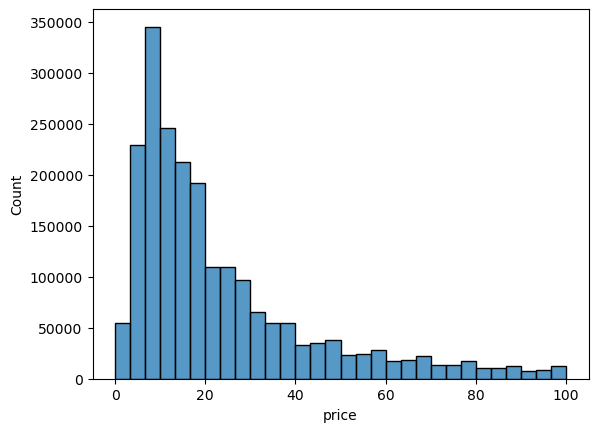

In [156]:
sns.histplot(df1['price'], kde=False, bins=30);

## Violin Plots:

* Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
* Which product category tends to have the highest median price? Don't filter here by top categories.

In [175]:
top_categories = df1['category'].value_counts().head(20).index.tolist()
df_filtered = df1[df1['category'].isin(top_categories)]

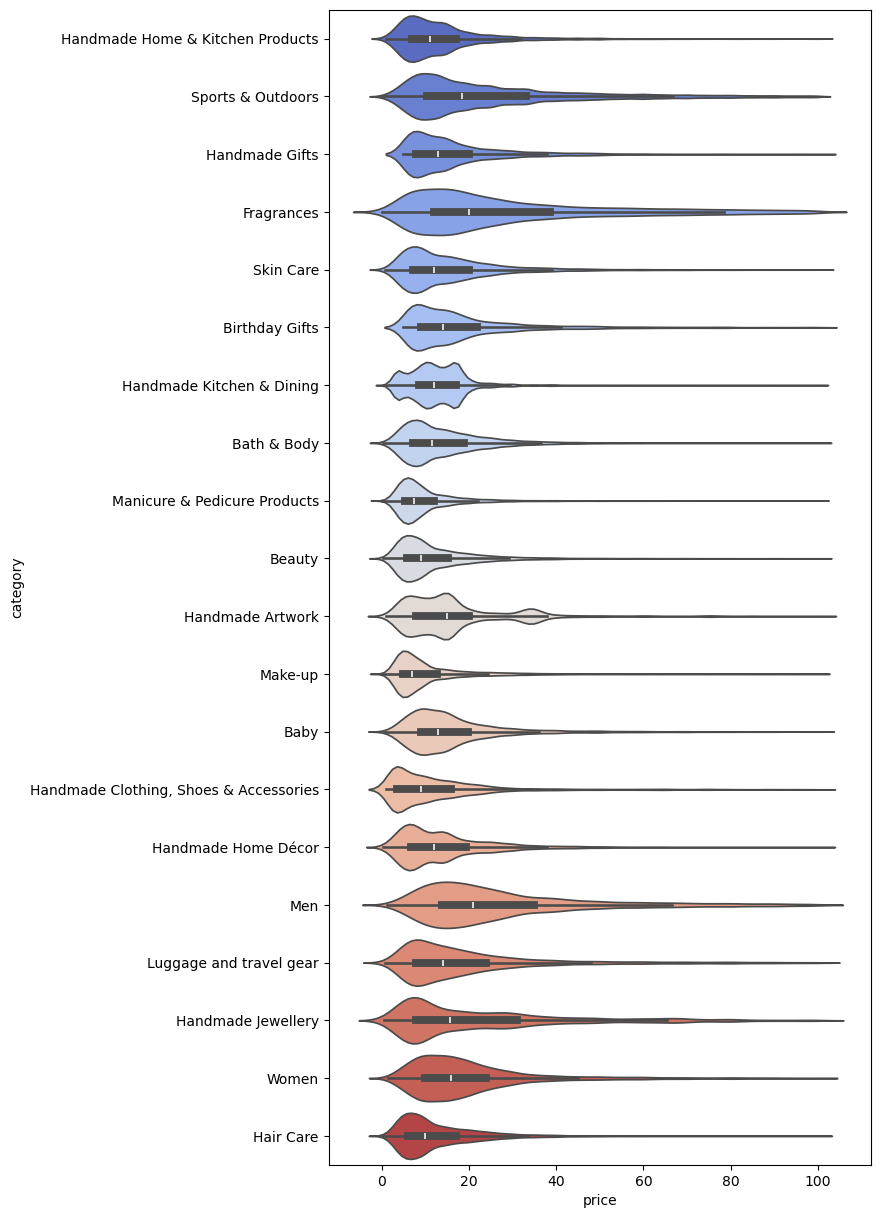

In [186]:
plt.figure(figsize=(7, 15))
sns.violinplot(data=df_filtered, x='price', y='category', palette="coolwarm", hue='category');

In [196]:
df1.groupby('category')['price'].median().sort_values(ascending=False)

category
Desktop PCs              74.00
Boxing Shoes             69.79
Tablets                  69.00
Graphics Cards           68.54
Motherboards             67.92
                         ...  
Adapters                  7.05
Make-up                   7.00
Signs & Plaques           6.99
Arts & Crafts             5.99
Office Paper Products     4.37
Name: price, Length: 296, dtype: float64

The category 'Desktops PCs' has the highest median price.

## Bar Charts:

* Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
* Which product category commands the highest average price? Don't filter here by top categories.

In [204]:
top_categories = df1['category'].value_counts().head(10).index.tolist()
df_filtered = df1[df1['category'].isin(top_categories)]

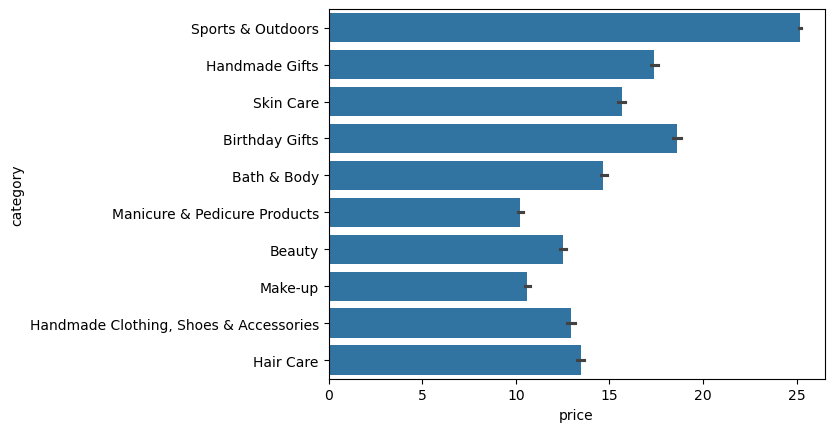

In [208]:
sns.barplot(data=df_filtered, x='price', y='category');

In [210]:
df1.groupby('category')['price'].mean().sort_values(ascending=False)

category
Motherboards             68.772432
Boxing Shoes             67.417803
Desktop PCs              66.915562
Tablets                  66.552971
Graphics Cards           65.103509
                           ...    
Bedding Accessories       8.835220
Adapters                  8.750197
Signs & Plaques           8.210513
Arts & Crafts             8.006540
Office Paper Products     6.876369
Name: price, Length: 296, dtype: float64

The highest average price isobsserved in the Motherboards category

## Box Plots:

* Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
* Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

sns.boxplot(data=df_filtered, x='price', y='category');

In [219]:
df1.groupby('category')['stars'].median().sort_values(ascending=False)

category
Computer Memory                 4.7
Building & Construction Toys    4.6
Office Paper Products           4.6
Luxury Food & Drink             4.6
Kids' Play Figures              4.6
                               ... 
Hockey Shoes                    0.0
Hi-Fi Receivers & Separates     0.0
Handmade Kitchen & Dining       0.0
Handmade Jewellery              0.0
eBook Readers & Accessories     0.0
Name: stars, Length: 296, dtype: float64

The hishest median rating is obsesrved in the computer Memory category

# Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

## Correlation Coefficients:

* Calculate the correlation coefficient between price and stars.
* Is there a significant correlation between product price and its rating?

In [225]:
correlation = df['price'].corr(df['stars'])
correlation

-0.1249067326214861

The correlation coefficient is about -0.12 and that indicates no strong linear correlation

## Visualizations:

* Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
* Use a correlation heatmap to visualize correlations between all numerical variables.
* Examine if product prices typically follow a normal distribution using a QQ plot.

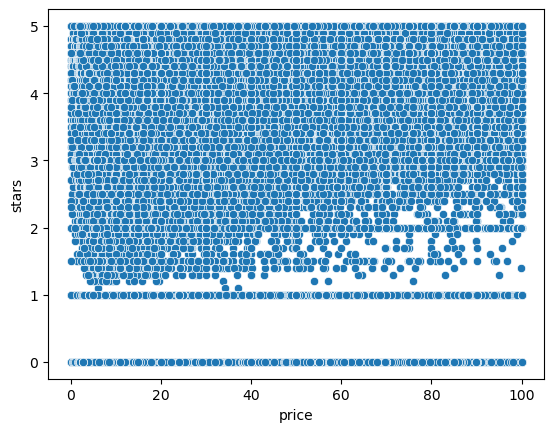

In [231]:
sns.scatterplot(data=df1, x='price', y='stars');

In [234]:
df1

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [240]:
df_numerical = df[['reviews', 'price', 'boughtInLastMonth']]
df_numerical

,reviews,price,boughtInLastMonth
0,15308,21.99,0
1,98099,23.99,0
2,15308,21.99,0
3,7205,31.99,0
4,1881,17.99,0
...,...,...,...
2443646,0,22.34,0
2443647,0,97.99,0
2443648,0,52.99,0
2443649,404,79.99,0


In [242]:
correlation_matrix = df_numerical.corr()

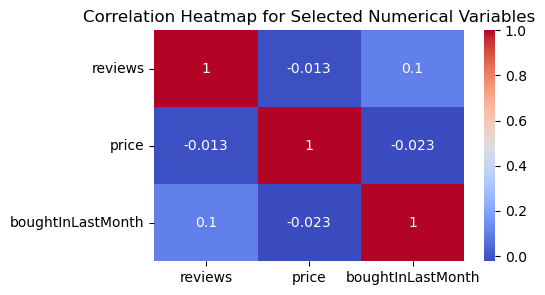

In [252]:
# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(5, 3))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

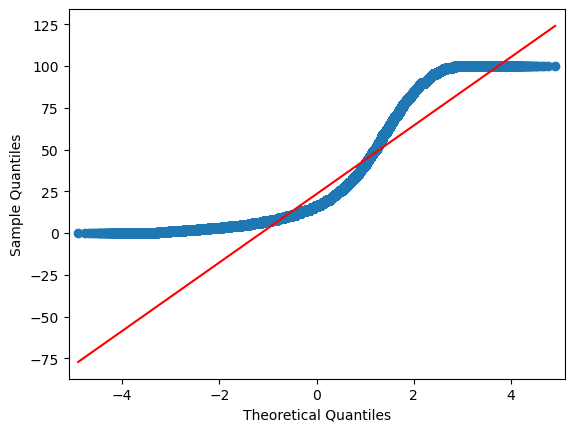

In [255]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(df1['price'], line='s');